In [6]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [1]:
import operator
import sys
from pyspark import SparkConf, SparkContext
import numpy as np
import matplotlib.pyplot as plt
import findspark
findspark.init()
from scipy import linalg
from sklearn.manifold import TSNE

In [2]:
# Macros.
MAX_ITER = 25
DATA_PATH = "data.txt"
C1_PATH = "c1.txt"
C2_PATH = "c2.txt"
NORM = 1  # change to 2 for l2 loss


In [3]:
# Helper functions.
def closest(p, centroids, norm):
    """
    Compute closest centroid for a given point.
    Args:
        p (numpy.ndarray): input point
        centroids (list): A list of centroids points
        norm (int): 1 or 2
    Returns:
        int: The index of closest centroid.
    """
    closest_c = min([(i, linalg.norm(p - c, norm) ** norm)
                     for i, c in enumerate(centroids)],
                    key=operator.itemgetter(1))[0]
    return closest_c

In [6]:
def loss(data, centroids, norm):
    """
    :param data: original data points in RDD
    :param centroids: centroids used to calculate loss
    :param norm: int 1 or 2
    :return: the loss based on centroids
    """
    norms = data.map(lambda point: linalg.norm(np.subtract(centroids[closest(
        point, centroids, norm=norm)], point), norm) ** norm)
    cost = norms.reduce(lambda norm1, norm2: norm1 + norm2)
    return cost

In [7]:
def plot_loss(loss1, loss2, img_path):
    fig = plt.figure(figsize=(12, 10))
    plt.plot(range(len(loss1)), loss1, "b", label="cost of c1 (kmean)")
    plt.plot(range(len(loss2)), loss2, "r", label="cost of c2 (kmean++)")
    plt.legend(loc="upper right", title="Classes")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    fig.savefig(img_path)

In [8]:
def plot_cluster(data, img_path):
    index = data.map(lambda x: x[0]).collect()
    points = data.map(lambda x: x[1][0]).collect()
    points_embedded = TSNE(n_components=2, perplexity=50,
                           random_state=100).fit_transform(points)
    fig = plt.figure(figsize=(12, 10))
    scatter = plt.scatter(points_embedded[:, 0], points_embedded[:, 1],
                          marker='o', c=index, cmap='jet')
    plt.legend(*scatter.legend_elements(),
               loc="upper right", title="Classes")
    fig.savefig(img_path)

In [9]:
# K-means clustering
def kmeans(data, centroids, norm=2):
    # iterative k-means
    # k = len(centroids)
    cost_ls = [loss(data=data, centroids=centroids, norm=norm)]
    for _ in range(MAX_ITER):
        # Transform each point to a combo of point, closest centroid, count=1
        # point -> (closest_centroid, (point, 1))
        # Re-compute cluster center
        # For each cluster center (key), aggregate its values
        # by summing up points and count
        # Average the points for each centroid: divide sum of points by count
        # Use collect() to turn RDD into list
        combo = data.map(lambda point: (closest(
            point, centroids, norm=norm), (point, 1)))
        centroids = combo.reduceByKey(lambda combo1, combo2: (
            np.add(combo1[0], combo2[0]),
            combo1[1] + combo2[1])).map(lambda x: np.divide(x[1][0], x[1][1]))
        centroids = centroids.collect()
        cost = loss(data=data, centroids=centroids, norm=norm)
        cost_ls.append(cost)
    combo = data.map(lambda point: (closest(
        point, centroids, norm=norm), (point, 1)))
    return combo, centroids, cost_ls

In [10]:
def main():
    # Spark settings
    conf = SparkConf().setMaster("local").setAppName("kmeans")
    sc = SparkContext(conf=conf)
    # Load the data, cache this since we're accessing this each iteration
    data = sc.textFile(DATA_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
    ).cache()
    # Load the initial centroids c1, split into a list of np arrays
    centroids1 = sc.textFile(C1_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
    ).collect()
    # Load the initial centroids c2, split into a list of np arrays
    centroids2 = sc.textFile(C2_PATH).map(
        lambda line: np.array([float(x) for x in line.split(' ')])
    ).collect()
    print("Run kmean clustering.")
    combo1, centroids1, cost1 = kmeans(data=data, centroids=centroids1,
                                       norm=NORM)
    print("Run kmean++ clustering.")
    combo2, centroids2, cost2 = kmeans(data=data, centroids=centroids2,
                                       norm=NORM)
    print("Plot loss.")
    plot_loss(cost1, cost2, "Anish.jpg")
    if NORM == 1:
        print("For L2 norm, plot 2D clustering result.")
        print("Plot kmean clustering result.")
        plot_cluster(combo1, "kmeans_2Dpoints.jpg")
        print("Plot kmean++ clustering result.")
        plot_cluster(combo2, "kmeans++_2Dpoints.jpg")
    print("Done!")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/07 08:50:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/07 08:50:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Run kmean clustering.


Run kmean++ clustering.


Plot loss.
For L2 norm, plot 2D clustering result.
Plot kmean clustering result.


/Users/achintamaneni5717/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/achintamaneni5717/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Plot kmean++ clustering result.


/Users/achintamaneni5717/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/achintamaneni5717/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Done!


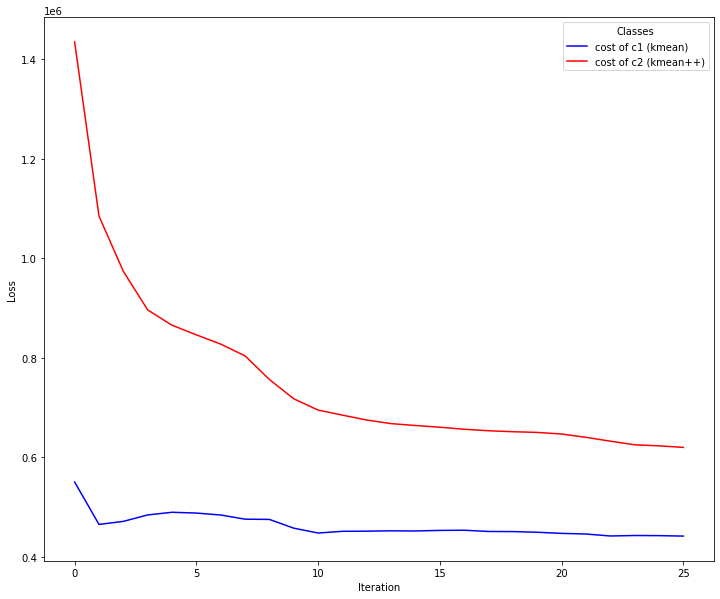

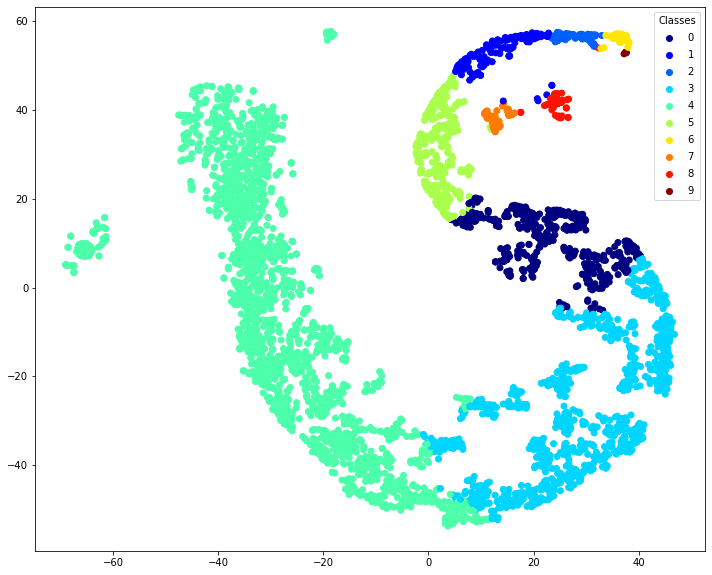

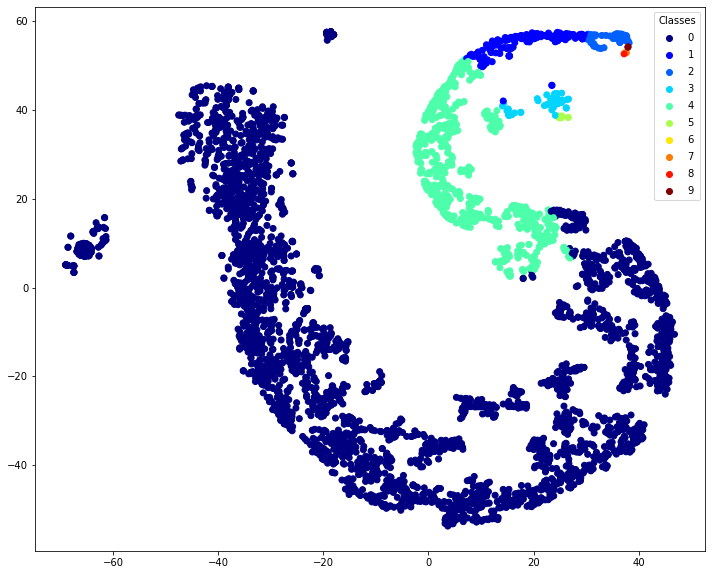

In [11]:
if __name__ == "__main__":
    main()  